# CASM Visibility Analysis
This notebook analyzes the visibility simulation results generated by the time-series simulation.

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from astropy.time import Time
from datetime import datetime
import pytz

In [89]:
# 1. Find the latest results directory
results_dirs = sorted(glob.glob("results_*"))
if not results_dirs:
    raise FileNotFoundError("No results directories found!")
latest_dir = results_dirs[-1]
print(f"Analyzing results from: {latest_dir}")

Analyzing results from: results_20251213_1652_to_20251214_1652


In [90]:
# 2. Load all visibility files and extract Source Data
vis_files = sorted(glob.glob(os.path.join(latest_dir, "visibilities", "*.npz")))
print(f"Found {len(vis_files)} visibility files")

data_list = []
times = []
sun_alts = []

# Assuming baselines and freqs are constant, load them from first file
first_data = np.load(vis_files[0])
baselines = first_data['baselines']
frequencies = first_data['frequencies']
baseline_pairs = first_data['baseline_pairs']

# Extract indices for the 3 test baselines
idx_auto = 0
idx_ew = 1 
idx_ns = 2

srcs = {}
srcs['Cas A'] = {'alt': [], 'az': []}
srcs['Cyg A'] = {'alt': [], 'az': []}
srcs['Tau A'] = {'alt': [], 'az': []}
srcs['Sun'] = {'alt': [], 'az': []}

pst = pytz.timezone('US/Pacific')

for f in vis_files:
    d = np.load(f)
    # Shape: (n_baselines, n_freq, 2, 2)
    vis = d['visibilities']
    t_iso = str(d['time_obs'])
    t_pst = Time(t_iso).to_datetime(timezone=pst)
    
    data_list.append(vis)
    times.append(t_pst)
    
    # Extract Source Altitudes
    src_names = d['source_names']
    src_alt = d['source_alt']
    
    # Find Sun
    # Note: src_names in npz might be byte strings or normal strings depending on numpy version
    # We assume standard encoding
    for src in srcs.keys():
        # try:
        src_idx = np.where(src_names == src)[0][0]
        srcs[src]['alt'].append(src_alt[src_idx])
        srcs[src]['az'].append(src_alt[src_idx])


# Stack into arrays
vis_array = np.array(data_list)
sun_alts = np.array(sun_alts)
print(f"Data shape: {vis_array.shape}")

Found 96 visibility files
Data shape: (96, 3, 5, 2, 2)


In [91]:
t_iso

'2025-12-15 00:37:38.925'

In [94]:
times

[datetime.datetime(2025, 12, 13, 16, 52, 38, 925000, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>),
 datetime.datetime(2025, 12, 13, 17, 7, 38, 925000, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>),
 datetime.datetime(2025, 12, 13, 17, 22, 38, 925000, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>),
 datetime.datetime(2025, 12, 13, 17, 37, 38, 925000, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>),
 datetime.datetime(2025, 12, 13, 17, 52, 38, 925000, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>),
 datetime.datetime(2025, 12, 13, 18, 7, 38, 925000, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>),
 datetime.datetime(2025, 12, 13, 18, 22, 38, 925000, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>),
 datetime.datetime(2025, 12, 13, 18, 37, 38, 925000, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>),
 datetime.datetime(2025, 12, 13, 18, 52, 38, 925000, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>),
 da

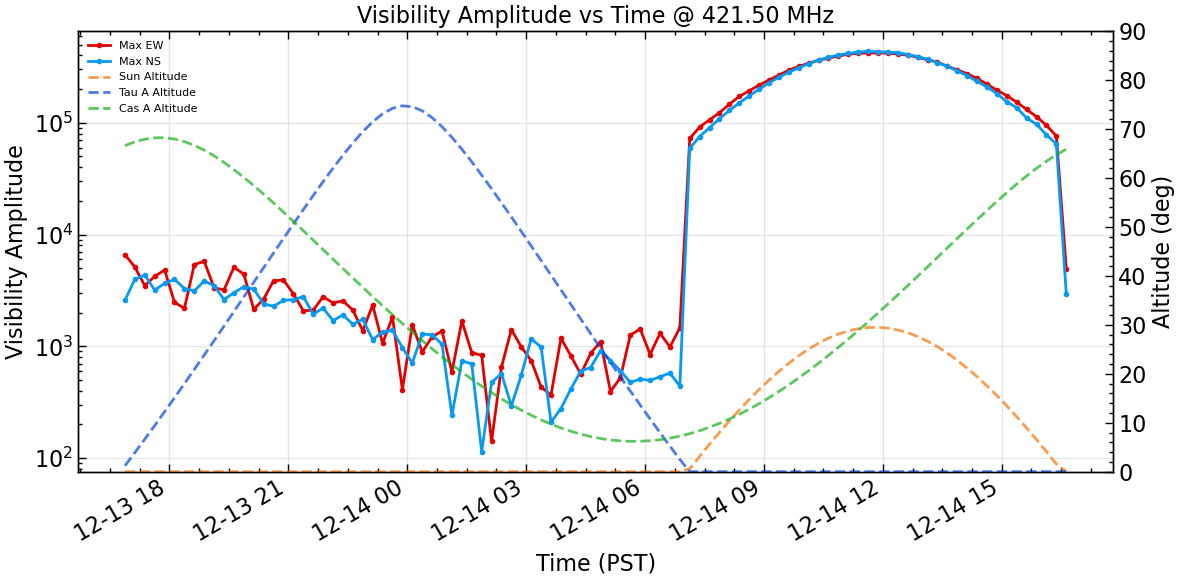

In [95]:
# 3. Plot Amplitude vs Time with Sun Altitude
mid_freq_idx = len(frequencies) // 2
freq_mhz = frequencies[mid_freq_idx]

amp_auto = np.abs(vis_array[:, idx_auto, mid_freq_idx, 0, 0])
amp_ew = np.abs(vis_array[:, idx_ew, mid_freq_idx, 0, 0])
amp_ns = np.abs(vis_array[:, idx_ns, mid_freq_idx, 0, 0])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Visibilities on Left Axis
# ax1.plot(times, amp_auto, label=f'Auto (Ant 0)', marker='.', color='C0')
ax1.plot(times, amp_ew, label=f'Max EW', marker='.', color='xkcd:red')
ax1.plot(times, amp_ns, label=f'Max NS', marker='.', color='xkcd:azure')
ax1.set_xlabel('Time (PST)')
ax1.set_ylabel('Visibility Amplitude', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot Sun Altitude on Right Axis
ax2 = ax1.twinx()
ax2.plot(times, srcs['Sun']['alt'], label='Sun Altitude', color='xkcd:orange', linestyle='--', linewidth=2, alpha=0.7)
ax2.plot(times, srcs['Tau A']['alt'], label='Tau A Altitude', color='xkcd:blue', linestyle='--', linewidth=2, alpha=0.7)
ax2.plot(times, srcs['Cas A']['alt'], label='Cas A Altitude', color='xkcd:green', linestyle='--', linewidth=2, alpha=0.7)
# ax2.plot(times, srcs['Cyg A']['alt'], label='Cyg A Altitude', color='xkcd:red', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_ylabel('Altitude (deg)')
ax2.tick_params(axis='y')
ax2.set_ylim(0, 90)  # Standard horizon to zenith

# Valid time formatting
fig.autofmt_xdate()

plt.title(f'Visibility Amplitude vs Time @ {freq_mhz:.2f} MHz')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize = 8)

plt.tight_layout()
plt.show()

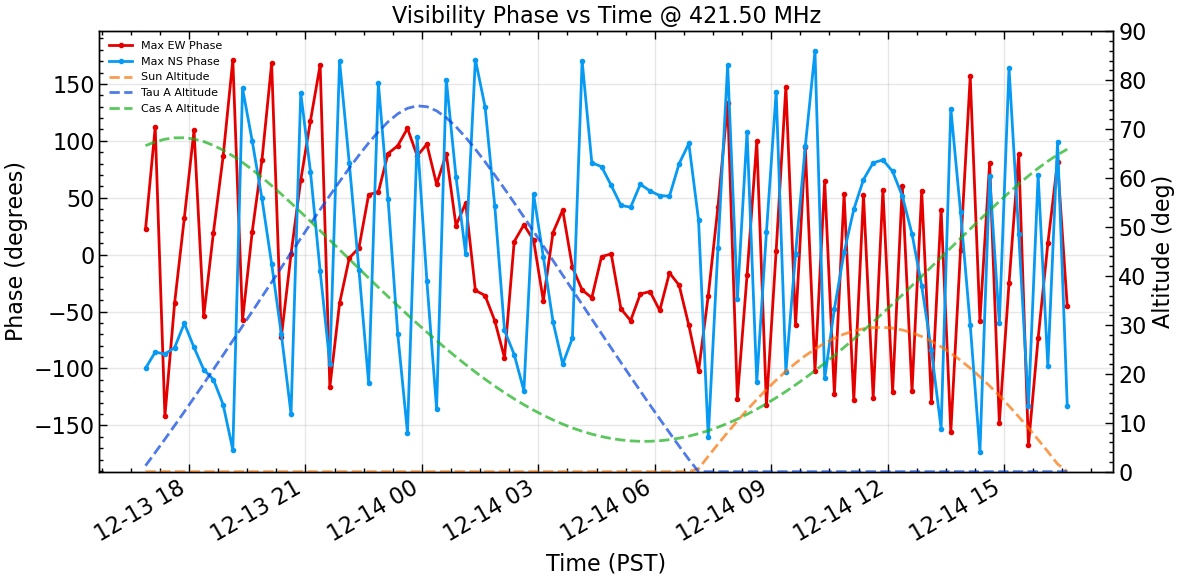

In [96]:
# 4. Plot Phase vs Time with Sun Altitude
phase_ew = np.angle(vis_array[:, idx_ew, mid_freq_idx, 0, 0])
phase_ns = np.angle(vis_array[:, idx_ns, mid_freq_idx, 0, 0])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Phases
ax1.plot(times, np.degrees(phase_ew), label='Max EW Phase', marker='.', color='xkcd:red')
ax1.plot(times, np.degrees(phase_ns), label='Max NS Phase', marker='.', color='xkcd:azure')
ax1.set_xlabel('Time (PST)')
ax1.set_ylabel('Phase (degrees)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# Plot Sun Altitude
ax2 = ax1.twinx()
ax2.plot(times, srcs['Sun']['alt'], label='Sun Altitude', color='xkcd:orange', linestyle='--', linewidth=2, alpha=0.7)
ax2.plot(times, srcs['Tau A']['alt'], label='Tau A Altitude', color='xkcd:blue', linestyle='--', linewidth=2, alpha=0.7)
ax2.plot(times, srcs['Cas A']['alt'], label='Cas A Altitude', color='xkcd:green', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_ylabel('Altitude (deg)')

ax2.tick_params(axis='y')
ax2.set_ylim(0, 90)

fig.autofmt_xdate()
plt.title(f'Visibility Phase vs Time @ {freq_mhz:.2f} MHz')

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()